## Setup The Enivorment 

In [1]:
# # only run this once
# %pip install -q git+https://github.com/tensorflow/docs
# %pip install tensorflow
# %pip -q install imutils
# %pip install opencv-python
# %pip install imageio
# %pip install seaborn
!pip install -q git+https://github.com/tensorflow/docs

!pip install -q git+https://github.com/tensorflow/docs

In [2]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os


2023-05-21 15:11:10.336787: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Preparation

### Hyperparameters

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 15

MAX_SEQ_LENGTH = 100
NUM_FEATURES = 2048

In [4]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 347
Total videos for testing: 81


video_name      tag
201      foul (57).avi     foul
100   redcard (37).avi  redcard
293  scoring (109).avi  scoring
112   scoring (71).avi  scoring
283  scoring (164).avi  scoring
133      foul (42).avi     foul
260   scoring (34).avi  scoring
329      foul (46).avi     foul
113   scoring (26).avi  scoring
163   redcard (35).avi  redcard

## Util functions for data preparation

In [5]:

def crop_center_square(frame):
    # Get the height and width of the input frame using the shape method
    y, x = frame.shape[0:2]
    
    # Calculate the minimum dimension of the input frame by finding the smaller of y and x
    min_dim = min(y, x)
    
    # Calculate the starting coordinates of the crop area so that the crop area is centered within the input frame
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    
    # Crop the center square from the input frame and return the result
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

import tensorflow as tf
import numpy as np

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE), augment=False):
    # Load the video at the given path using OpenCV
    cap = cv2.VideoCapture(path)
    
    # Create an empty list to hold the frames
    frames = []

    # Create an image generator for data augmentation
    if augment:
        data_gen_args = dict(zoom_range=0.2, horizontal_flip=True)
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

    try:
        # Loop over each frame in the video
        while True:
            # Read the next frame from the video
            ret, frame = cap.read()
            
            # If we have reached the end of the video, break out of the loop
            if not ret:
                break
            
            # Crop the frame to a square in the center of the image
            frame = crop_center_square(frame)
            
            # Resize the frame to the specified size
            frame = cv2.resize(frame, resize)
            
            # Reorder the color channels from BGR to RGB
            frame = frame[:, :, [2, 1, 0]]

            # Apply data augmentation if needed
            if augment:
                frame = datagen.random_transform(frame)
            
            # Add the processed frame to the list of frames
            frames.append(frame)

            # If we have reached the maximum number of frames, break out of the loop
            if len(frames) == max_frames:
                break
                
    finally:
        # Release the video capture object
        cap.release()
    
    # Convert the list of frames to a NumPy array and return it
    return np.array(frames)


"""
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    # Load the video at the given path using OpenCV
    cap = cv2.VideoCapture(path)
    
    # Create an empty list to hold the frames
    frames = []
    
    try:
        # Loop over each frame in the video
        while True:
            # Read the next frame from the video
            ret, frame = cap.read()
            
            # If we have reached the end of the video, break out of the loop
            if not ret:
                break
            
            # Crop the frame to a square in the center of the image
            frame = crop_center_square(frame)
            
            # Resize the frame to the specified size
            frame = cv2.resize(frame, resize)
            
            # Reorder the color channels from BGR to RGB
            frame = frame[:, :, [2, 1, 0]]
            
            # Add the processed frame to the list of frames
            frames.append(frame)

            # If we have reached the maximum number of frames, break out of the loop
            if len(frames) == max_frames:
                break
                
    finally:
        # Release the video capture object
        cap.release()
    
    # Convert the list of frames to a NumPy array and return it
    return np.array(frames)
"""

'\ndef load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):\n    # Load the video at the given path using OpenCV\n    cap = cv2.VideoCapture(path)\n    \n    # Create an empty list to hold the frames\n    frames = []\n    \n    try:\n        # Loop over each frame in the video\n        while True:\n            # Read the next frame from the video\n            ret, frame = cap.read()\n            \n            # If we have reached the end of the video, break out of the loop\n            if not ret:\n                break\n            \n            # Crop the frame to a square in the center of the image\n            frame = crop_center_square(frame)\n            \n            # Resize the frame to the specified size\n            frame = cv2.resize(frame, resize)\n            \n            # Reorder the color channels from BGR to RGB\n            frame = frame[:, :, [2, 1, 0]]\n            \n            # Add the processed frame to the list of frames\n            frames.append(fra

In [6]:
def build_feature_extractor():
    # Create an instance of the InceptionV3 model from Keras with pre-trained weights from ImageNet.
    # Set include_top=False to exclude the final dense layer of the model, which is used for classification.
    # Set pooling='avg' to use global average pooling instead of flattening the feature maps.
    # Set input_shape to the desired size of the input images (IMG_SIZE x IMG_SIZE) and 3 color channels.
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    
    # Create a function that will preprocess input images before passing them to the feature extractor.
    # The specific preprocessing steps are defined by the InceptionV3 model architecture.
    preprocess_input = keras.applications.inception_v3.preprocess_input

    # Define the input layer of the model with shape (IMG_SIZE, IMG_SIZE, 3).
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    
    # Preprocess the input by applying the `preprocess_input` function to it.
    preprocessed = preprocess_input(inputs)

    # Pass the preprocessed input through the feature extractor to obtain a feature vector.
    outputs = feature_extractor(preprocessed)
    
    # Create and return a new Keras model with the same input and output layers as the feature extractor.
    return keras.Model(inputs, outputs, name="feature_extractor")

# create a pre-trained feature extractor 
feature_extractor = build_feature_extractor()

In [7]:
# Create a StringLookup layer to map string labels to integer indices
# num_oov_indices=0 sets the number of out-of-vocabulary indices to 0
# vocabulary is a numpy array of unique labels in the "tag" column of the train_df DataFrame
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
print(label_processor.get_vocabulary())

['foul', 'redcard', 'scoring']


In [8]:

def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()
    

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]
        
        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
        

        

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "data/train")
test_data, test_labels = prepare_all_videos(test_df, "data/test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")



1/1 [==============================] - 0s 108ms/step
Frame features in train set: (347, 100, 2048)
Frame masks in train set: (347, 100)


## Creating and training the model


In [9]:
from keras.layers import BatchNormalization
from keras.callbacks import LearningRateScheduler
from keras.utils import pad_sequences
from keras.layers import Bidirectional, LSTM
from keras import regularizers
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Setting a random seed for reproducibility
tf.random.set_seed(42)

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Increased the units in LSTM layers
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.5))(frame_features_input, mask=mask_input)
    x = Bidirectional(LSTM(32, return_sequences=True, dropout=0.5))(x, mask=mask_input)
    x = LSTM(16)(x)
    
    # Added Batch Normalization layer
    x = BatchNormalization()(x)
    
    x = keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    # Adjust the learning rate
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )
    return rnn_model

def run_experiment():
    filepath = "./tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.power(0.7, epoch//20))

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    histories = []
    models = []
    accuracies = []
    for i, (train_index, val_index) in enumerate(kfold.split(train_data[0])):
        print(f'Running fold {i+1}')
        train_data_fold = [data[train_index] for data in train_data]
        val_data_fold = [data[val_index] for data in train_data]
        train_labels_fold = train_labels[train_index]
        val_labels_fold = train_labels[val_index]

        seq_model = get_sequence_model()
        history = seq_model.fit(
            train_data_fold,
            train_labels_fold,
            validation_data=(val_data_fold, val_labels_fold),
            epochs=30,
            callbacks=[checkpoint, early_stopping, lr_schedule],
        )
        seq_model.load_weights(filepath)

        _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
        print(f"Test accuracy: {round(accuracy * 100, 2)}%")
        histories.append(history)
        models.append(seq_model)
        accuracies.append(accuracy)

    print(f"Average test accuracy: {round(np.mean(accuracies) * 100, 2)}%")
    return histories, models

histories, models = run_experiment()


Running fold 1
Epoch 1/30


2023-05-21 16:51:17.601668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-21 16:51:18.273761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-21 16:51:24.425967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ign

9/9 [==============================] - ETA: 0s - loss: 1.7944 - accuracy: 0.3935
Epoch 1: val_loss improved from inf to 1.67545, saving model to ./tmp/video_classifier
9/9 [==============================] - 31s 1s/step - loss: 1.7944 - accuracy: 0.3935 - val_loss: 1.6754 - val_accuracy: 0.6857 - lr: 0.0010
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.5565 - accuracy: 0.5993
Epoch 2: val_loss improved from 1.67545 to 1.58706, saving model to ./tmp/video_classifier
9/9 [==============================] - 6s 684ms/step - loss: 1.5565 - accuracy: 0.5993 - val_loss: 1.5871 - val_accuracy: 0.6857 - lr: 0.0010
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.3692 - accuracy: 0.6895
Epoch 3: val_loss improved from 1.58706 to 1.43744, saving model to ./tmp/video_classifier
9/9 [==============================] - 6s 692ms/step - loss: 1.3692 - accuracy: 0.6895 - val_loss: 1.4374 - val_accuracy: 0.8429 - lr: 0.0010
Epoch 4/30
9/9 [==========================

2023-05-21 16:54:32.597991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-21 16:54:33.238585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-21 16:54:38.998264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ign

9/9 [==============================] - ETA: 0s - loss: 1.5344 - accuracy: 0.6751
Epoch 1: val_loss did not improve from 0.51554
9/9 [==============================] - 28s 1s/step - loss: 1.5344 - accuracy: 0.6751 - val_loss: 1.6851 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.4258 - accuracy: 0.6787
Epoch 2: val_loss did not improve from 0.51554
9/9 [==============================] - 5s 583ms/step - loss: 1.4258 - accuracy: 0.6787 - val_loss: 1.5459 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.2684 - accuracy: 0.7401
Epoch 3: val_loss did not improve from 0.51554
9/9 [==============================] - 5s 603ms/step - loss: 1.2684 - accuracy: 0.7401 - val_loss: 1.4981 - val_accuracy: 0.6571 - lr: 0.0010
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 1.1493 - accuracy: 0.7798
Epoch 4: val_loss did not improve from 0.51554
9/9 [==========================

2023-05-21 16:57:57.960168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-21 16:57:59.561225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-21 16:58:05.106618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ign

9/9 [==============================] - ETA: 0s - loss: 1.8903 - accuracy: 0.3417
Epoch 1: val_loss did not improve from 0.51554
9/9 [==============================] - 29s 1s/step - loss: 1.8903 - accuracy: 0.3417 - val_loss: 1.7149 - val_accuracy: 0.4493 - lr: 0.0010
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.6122 - accuracy: 0.5252
Epoch 2: val_loss did not improve from 0.51554
9/9 [==============================] - 5s 600ms/step - loss: 1.6122 - accuracy: 0.5252 - val_loss: 1.6255 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.4204 - accuracy: 0.6835
Epoch 3: val_loss did not improve from 0.51554
9/9 [==============================] - 6s 671ms/step - loss: 1.4204 - accuracy: 0.6835 - val_loss: 1.5014 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 1.2943 - accuracy: 0.7554
Epoch 4: val_loss did not improve from 0.51554
9/9 [==========================

2023-05-21 17:01:29.663297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-21 17:01:30.364180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-21 17:01:36.124079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ign

9/9 [==============================] - ETA: 0s - loss: 1.5335 - accuracy: 0.6439
Epoch 1: val_loss did not improve from 0.51554
9/9 [==============================] - 30s 1s/step - loss: 1.5335 - accuracy: 0.6439 - val_loss: 1.6299 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.3499 - accuracy: 0.7014
Epoch 2: val_loss did not improve from 0.51554
9/9 [==============================] - 5s 607ms/step - loss: 1.3499 - accuracy: 0.7014 - val_loss: 1.5637 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.2016 - accuracy: 0.7590
Epoch 3: val_loss did not improve from 0.51554
9/9 [==============================] - 6s 657ms/step - loss: 1.2016 - accuracy: 0.7590 - val_loss: 1.4697 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 1.1104 - accuracy: 0.8094
Epoch 4: val_loss did not improve from 0.51554
9/9 [==========================

2023-05-21 17:04:54.476468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-21 17:04:55.190499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-21 17:05:00.968274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ign

9/9 [==============================] - ETA: 0s - loss: 1.7153 - accuracy: 0.4928
Epoch 1: val_loss did not improve from 0.51554
9/9 [==============================] - 28s 1s/step - loss: 1.7153 - accuracy: 0.4928 - val_loss: 1.7325 - val_accuracy: 0.5652 - lr: 0.0010
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.4895 - accuracy: 0.6475
Epoch 2: val_loss did not improve from 0.51554
9/9 [==============================] - 5s 590ms/step - loss: 1.4895 - accuracy: 0.6475 - val_loss: 1.5734 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.3562 - accuracy: 0.7122
Epoch 3: val_loss did not improve from 0.51554
9/9 [==============================] - 6s 652ms/step - loss: 1.3562 - accuracy: 0.7122 - val_loss: 1.4450 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 1.2093 - accuracy: 0.7554
Epoch 4: val_loss did not improve from 0.51554
9/9 [==========================

3/3 [==============================] - 6s 135ms/step
[[2.27758056e-03 1.10610365e-03 9.96616185e-01]
 [1.85438467e-03 9.03791573e-04 9.97241795e-01]
 [1.86141802e-03 8.41091038e-04 9.97297466e-01]
 [9.63065326e-01 9.04524606e-03 2.78893914e-02]
 [2.21112813e-03 1.10045972e-03 9.96688247e-01]
 [3.56644625e-03 1.73237640e-03 9.94701087e-01]
 [2.54561938e-03 1.19131699e-03 9.96263146e-01]
 [1.60924101e-03 7.42668402e-04 9.97648060e-01]
 [9.67709720e-01 1.18076708e-02 2.04824787e-02]
 [3.35609098e-03 1.53976271e-03 9.95104015e-01]
 [9.84135807e-01 5.02749020e-03 1.08366655e-02]
 [9.85857785e-01 4.53379937e-03 9.60848015e-03]
 [1.71545963e-03 9.10133240e-04 9.97374356e-01]
 [6.27800357e-03 9.82091308e-01 1.16306571e-02]
 [9.76519942e-01 7.42440391e-03 1.60556640e-02]
 [1.09312616e-01 4.16773967e-02 8.49009871e-01]
 [1.82952511e-03 9.08797141e-04 9.97261643e-01]
 [1.98491151e-03 9.66832682e-04 9.97048259e-01]
 [2.73500732e-03 1.30795094e-03 9.95957196e-01]
 [5.77076757e-03 2.88848532e-03 9.9

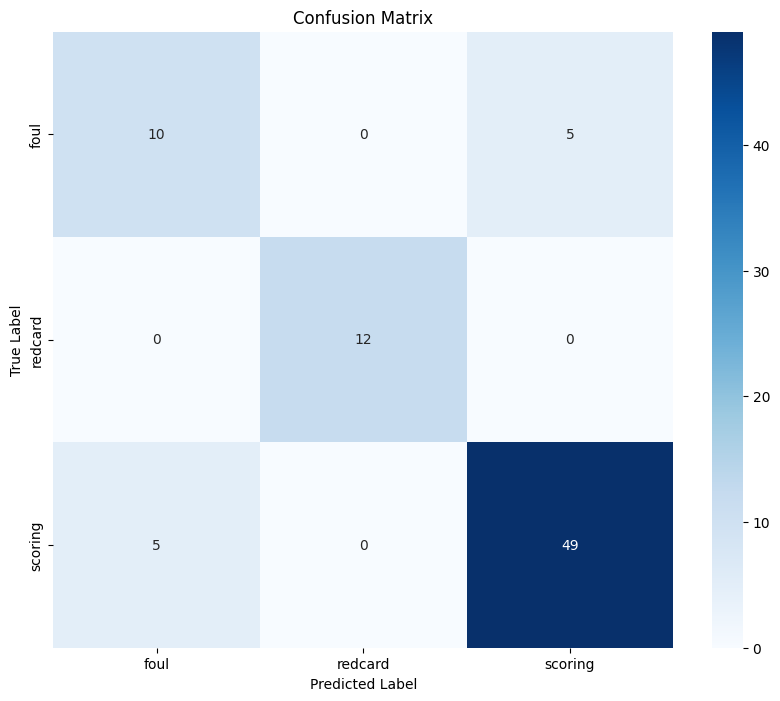

In [10]:
# Get predictions for the test data and average them
y_pred = np.mean([model.predict([test_data[0], test_data[1]]) for model in models], axis=0)
print(y_pred)

# Convert predictions from probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
print(y_pred_labels)

# Create the confusion matrix
cm = confusion_matrix(test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=label_processor.get_vocabulary(), yticklabels=label_processor.get_vocabulary())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [11]:
ff = pd.read_csv('data/test.csv')
a = ff['tag'].value_counts()
print('count',a)


count tag
scoring    54
foul       15
redcard    12
Name: count, dtype: int64


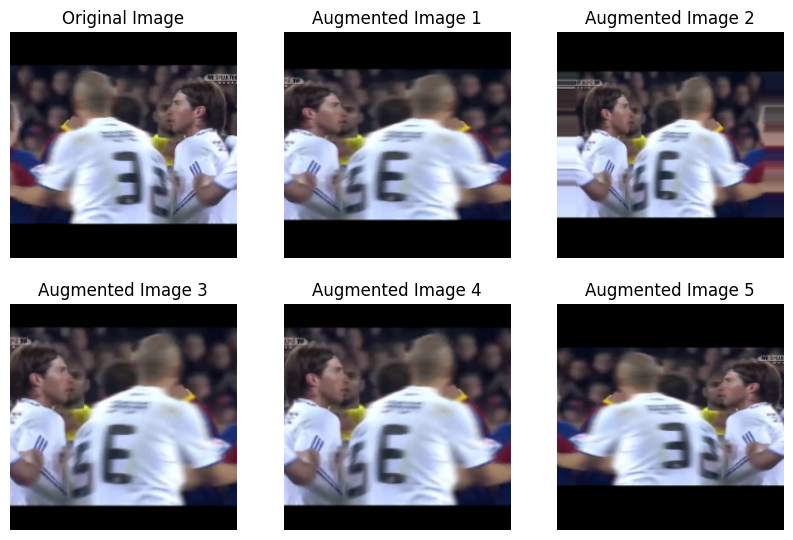

In [12]:
import matplotlib.pyplot as plt

# Load a video
video_frames = load_video('data/train/redcard (19).avi', max_frames=10, augment=False)

# Choose a frame
chosen_frame = video_frames[5]

# Create an image generator for data augmentation
data_gen_args = dict(zoom_range=0.2, horizontal_flip=True)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

# Prepare the augmentor
augmentor = datagen.flow(np.expand_dims(chosen_frame, 0), batch_size=1)

# Generate augmented images
augmented_images = [next(augmentor)[0].astype(np.uint8) for _ in range(5)]

# Plot the original image and augmented images
plt.figure(figsize=(10, 10))

plt.subplot(3, 3, 1)
plt.title("Original Image")
plt.imshow(chosen_frame)
plt.axis("off")

for i in range(5):
    ax = plt.subplot(3, 3, i + 2)
    plt.title("Augmented Image {}".format(i+1))
    plt.imshow(augmented_images[i])
    plt.axis("off")

plt.show()


## Testing the Model

Test video path: scoring (238).avi
1/1 [==============================] - 0s 53ms/step
  scoring: 99.66%
  foul:  0.23%
  redcard:  0.11%



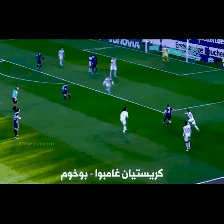

In [13]:
import imageio
import tensorflow as tf
from IPython.display import HTML, display
import base64

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("data/test", path))
    frame_features, frame_mask = prepare_single_video(frames)

    # Generate predictions from all models and average them
    probabilities = np.mean([model.predict([frame_features, frame_mask])[0] for model in models], axis=0)

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames  # return frames here



# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    if len(images) == 0:
        print("No frames to convert into a GIF.")
        return
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=33.33)
    return embed.embed_file("animation.gif")



def display_gif(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <img src="data:image/gif;base64,{0}"/>
    '''.format(b64.decode())

    return HTML(tag)


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames)


TESTING ON VIDEO THE MODEL HASNT SEEN

Test video path: new2.mp4
1/1 [==============================] - 0s 46ms/step
  foul: 91.04%
  scoring:  7.04%
  redcard:  1.92%



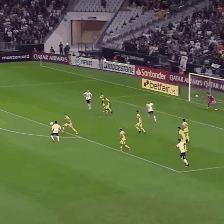

In [17]:
import imageio
import tensorflow as tf
from IPython.display import HTML, display
import base64

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(path)
    frame_features, frame_mask = prepare_single_video(frames)

    # Generate predictions from all models and average them
    probabilities = np.mean([model.predict([frame_features, frame_mask])[0] for model in models], axis=0)

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames  # return frames here



# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    if len(images) == 0:
        print("No frames to convert into a GIF.")
        return
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=33.33)
    return embed.embed_file("animation.gif")



def display_gif(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <img src="data:image/gif;base64,{0}"/>
    '''.format(b64.decode())

    return HTML(tag)


# Here, replace 'path/to/your/video' with the actual path to the video you want to test
test_video = 'new2.mp4'
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames)
